## Process and Visualize IWG data from Arctic Heat

Arctic Heat IWG files are obtained during aircraft flights.  Using python and a few standard data analysis and visualization packages, we can take a few quick looks into the data.

**Note** GMT-Python is in heavy development and may not be available unless you are on a mac or linux machine.  Alternatives are Cartopy or outputing your data into your favorite GIS software.

For more information on the analysis, contact: Shaun.Bell@noaa.gov

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cmocean

import pandas as pd
import numpy as np

import os

/Users/bell/anaconda2/envs/gmt-python/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


### Data Ingestion and data summary/statistics

A few lines to list and read the .iwg files into a dictionary of pandas dataframes.

The original .iwg files have headerlines everyso often through the file.  I usually clean these up by removing all of the lines and adding one iteration of headers at the top of the file and then call these files ".clean"

In [2]:
source_dir = '/Users/bell/ecoraid/2018/Additional_FieldData/ArcticHeat/IWG_data/'
source_file = [x for x in os.listdir(source_dir) if x.endswith('.clean.txt')]

In [3]:
dfs = {}
for i,filename in enumerate(source_file):
    print(filename)
    dfs.update({filename:pd.read_csv(source_dir + filename,delimiter=',',parse_dates=['TIME'],index_col='TIME')})

20180529_200826_IWG.clean.txt
20180530_010157_IWG.clean.txt
20180527_210946_IWG.clean.txt
20180531_210924_IWG.clean.txt
20180525_221008_IWG.clean.txt


In [4]:
for file in dfs.keys():
    print("Summary for file:{}".format(file))
    print(dfs[file].describe())

Summary for file:20180529_200826_IWG.clean.txt
                LAT           LON        ALTGPS  GPS_GEOIDHT      ALTPAFT  \
count  16452.000000  16452.000000  16452.000000          0.0  16452.00000   
mean      69.021807   -164.812521    411.429613          NaN   1397.96195   
std        3.132130      7.193147    420.766647          NaN   1389.41204   
min        0.000000   -168.551392      0.000000          NaN    -30.00000   
25%       67.048363   -167.925361    171.000000          NaN    650.00000   
50%       69.462677   -166.407463    210.000000          NaN    740.00000   
75%       70.739437   -162.631844    409.500000          NaN   1370.00000   
max       71.285980      0.000000   1369.000000          NaN   4600.00000   

            ALTRAFT            GS           TAS           IAS          MACH  \
count  16452.000000  16452.000000  16452.000000  16452.000000  16452.000000   
mean     535.143448     67.531548     68.460714    126.026076      0.195127   
std      477.029038   

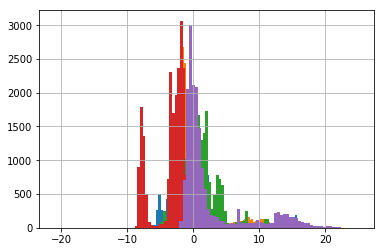

In [5]:
for file in dfs.keys():
    dfs[file]['SST'].hist(bins=100)

### Geolocated Plots of SST/Flight Altitude using GMT-Python

After having imported and glanced at the data and statistics, lets plot the SST as a function of flight path

In [6]:
import gmt

In [21]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 66, 77], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

In [22]:
#choose temp boundaries
upper_limit = 5
lower_limit = -2

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['SST'].loc[(dfs[file]['SST'] > upper_limit ) | (dfs[file]['SST'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['SST'].apply(lambda x: (x - (lower_limit)) / (upper_limit - (lower_limit)))
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=256*dfnorm, cmap='thermal', style='c0.1c')


/Users/bell/anaconda2/envs/gmt-python/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


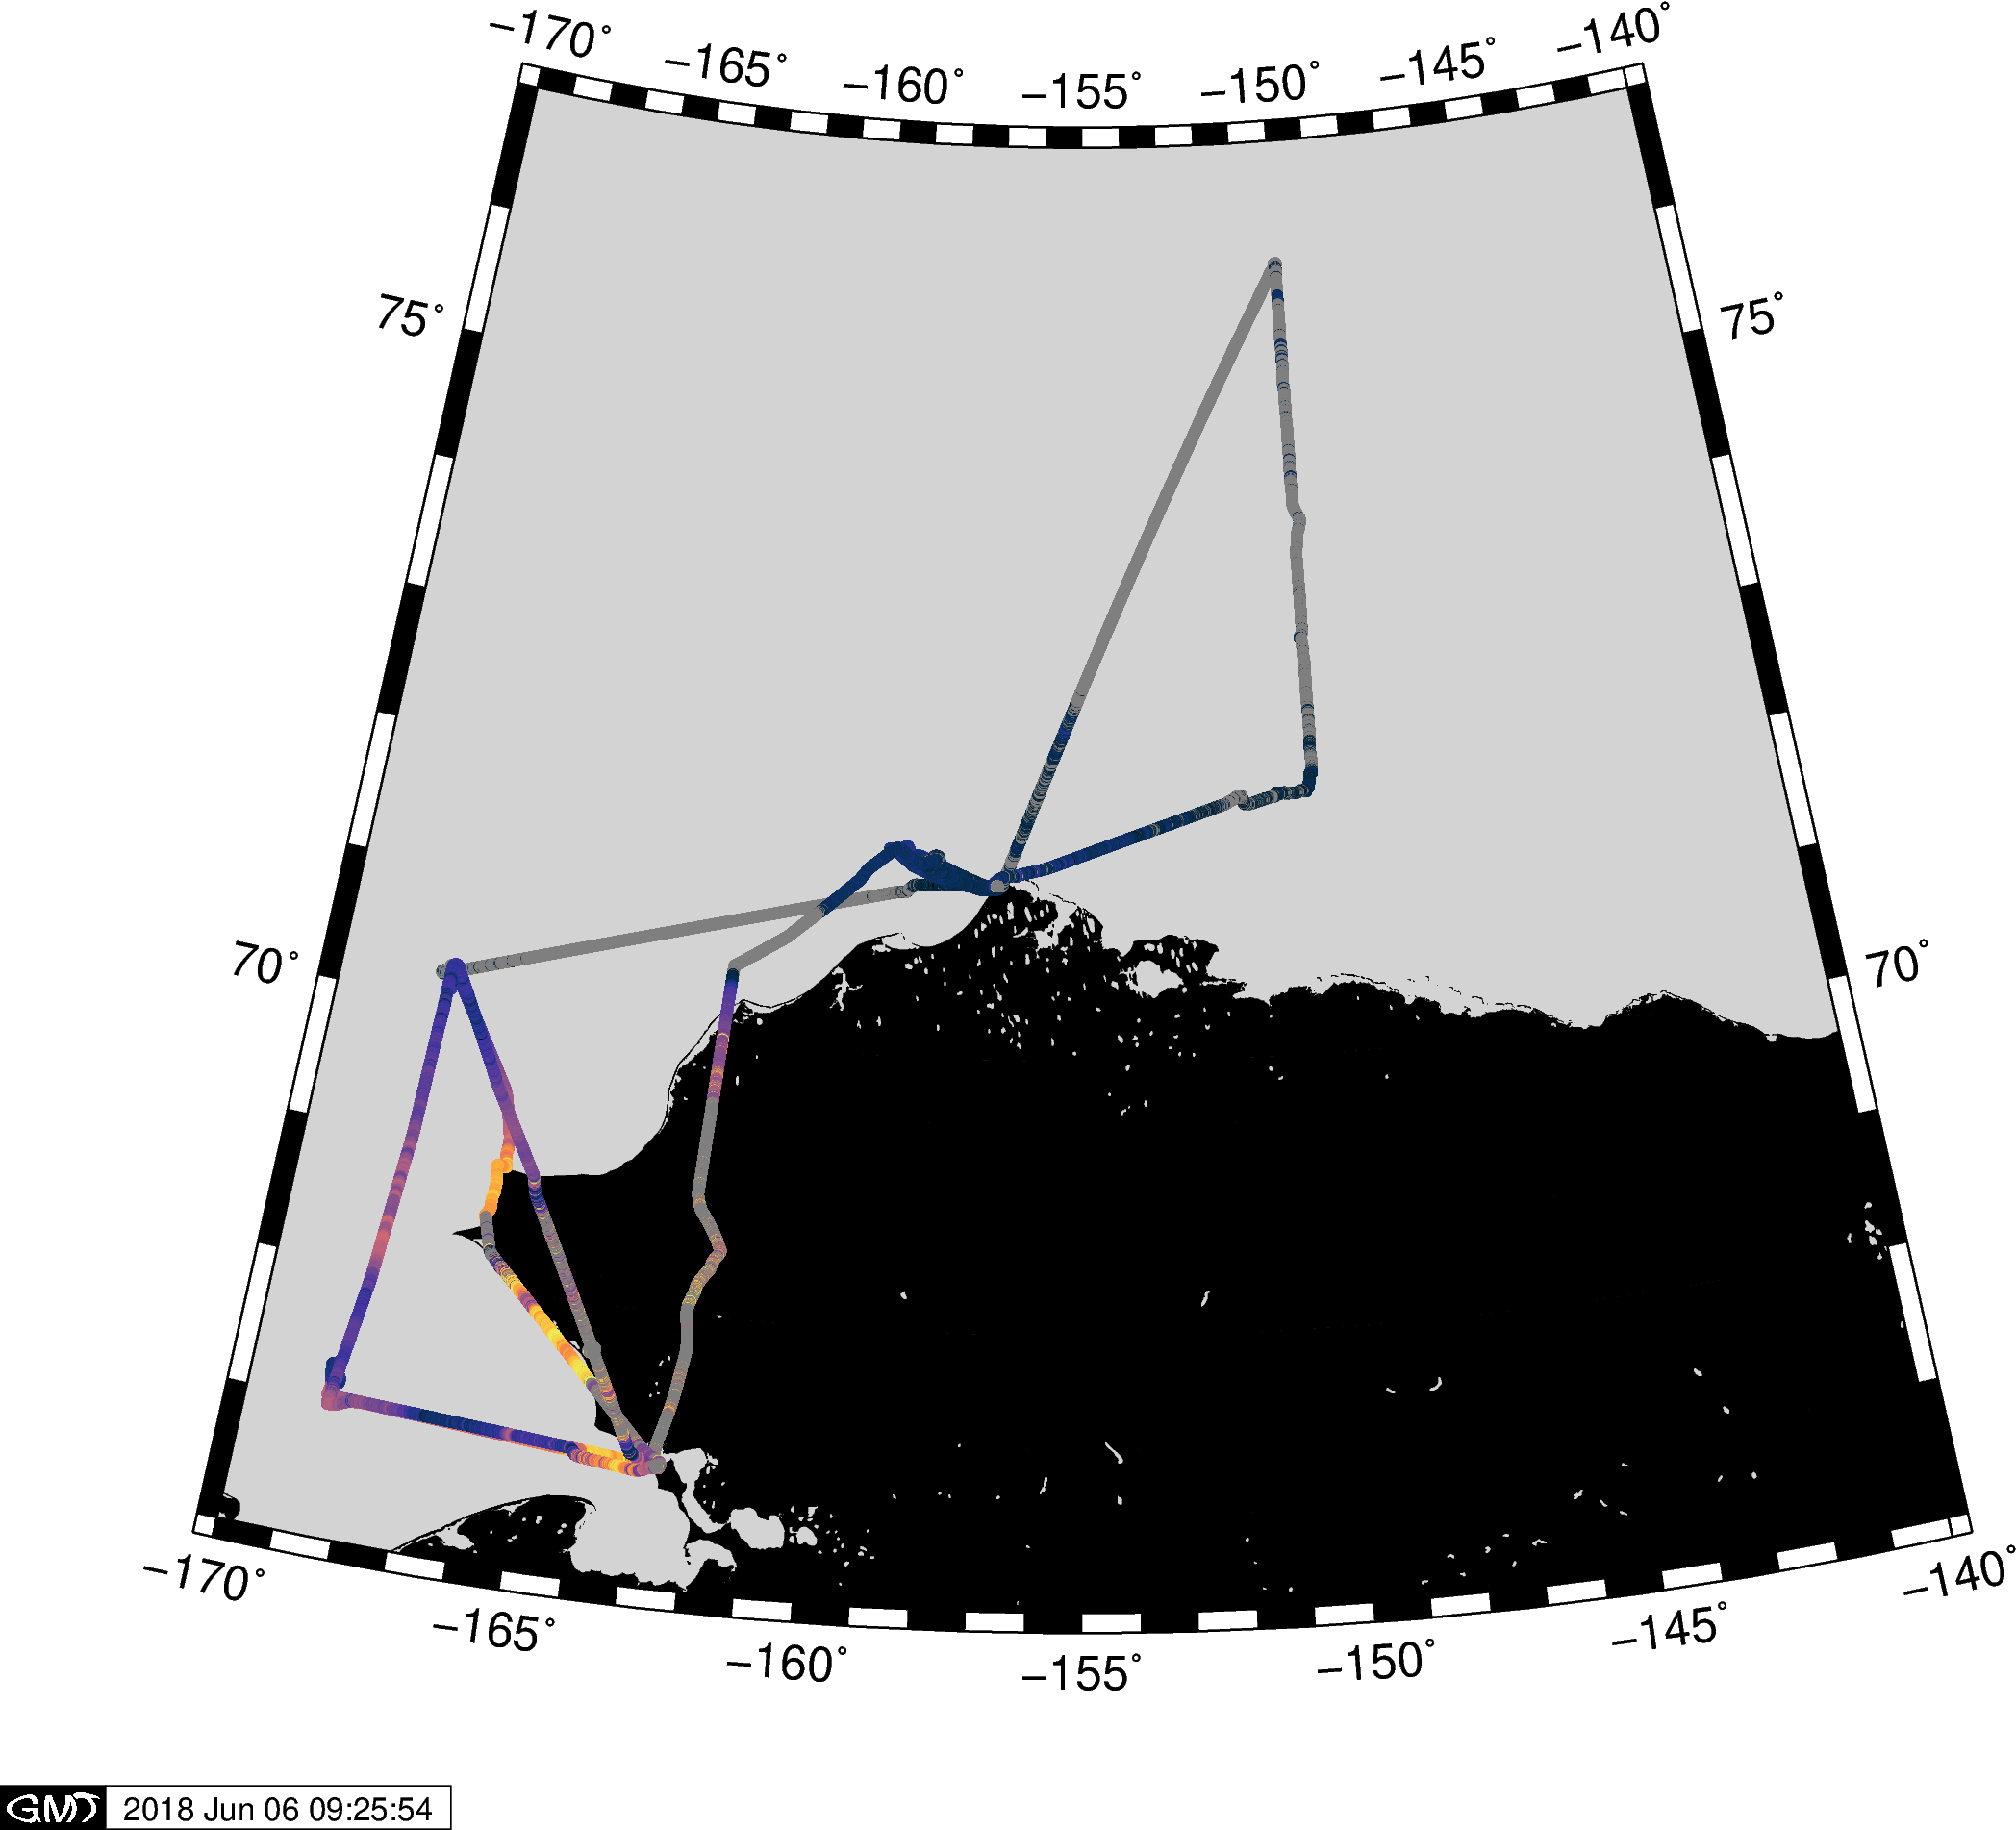

In [23]:
fig.show()

In [19]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 66, 77], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

/Users/bell/anaconda2/envs/gmt-python/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


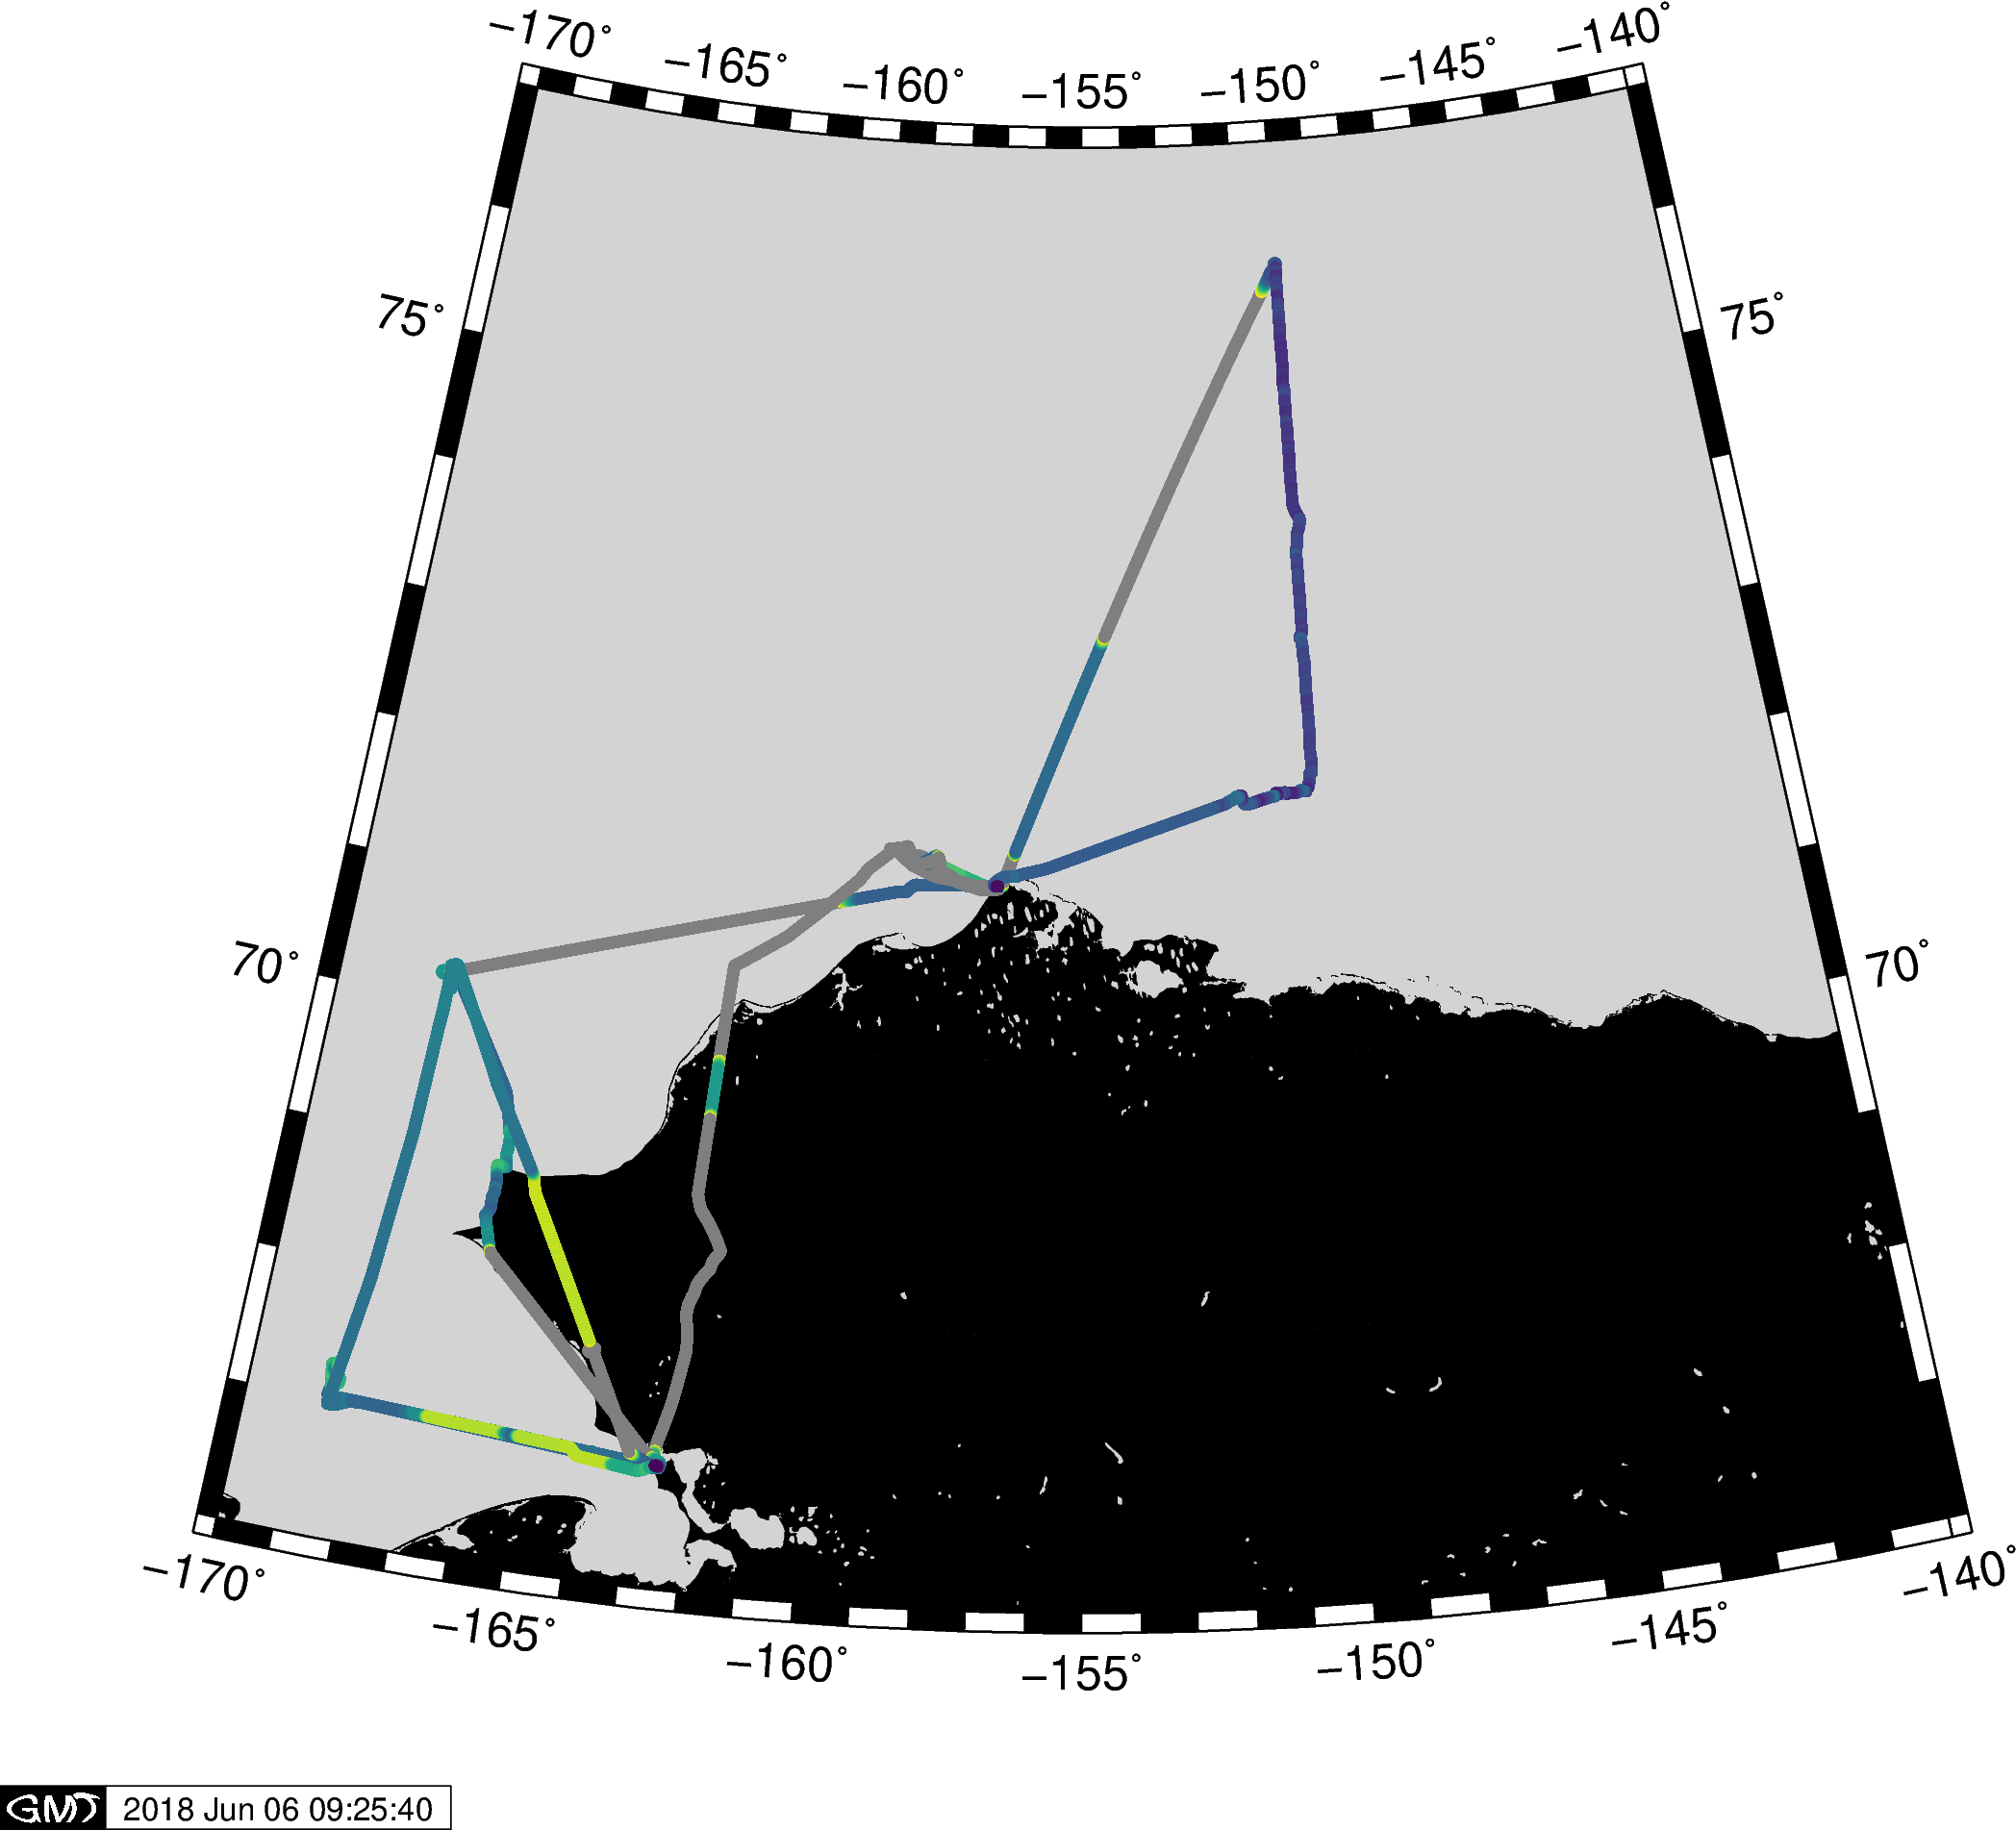

In [20]:
#choose altitude boundaries
upper_alt = 500 #ft
#lower is 0ft

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['ALTGPS'].loc[(dfs[file]['ALTGPS'] > upper_alt ) | (dfs[file]['ALTGPS'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['ALTGPS'].apply(lambda x: (x - (0)) / (upper_alt - (0)))
    #if a cmocean colormap is used like thermal - then you need to add it to your gmt-python env
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=dfnorm, cmap='viridis', style='c0.1c')

fig.show()

areas greyed out above are above 500ft.  darker blue regions are lower while lighter green regions are higher

### Plotting Time vs Altitude color coded by SST

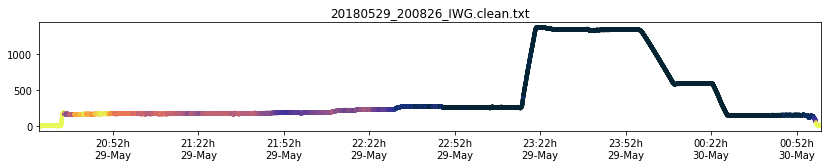

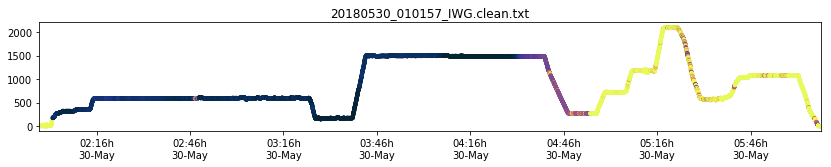

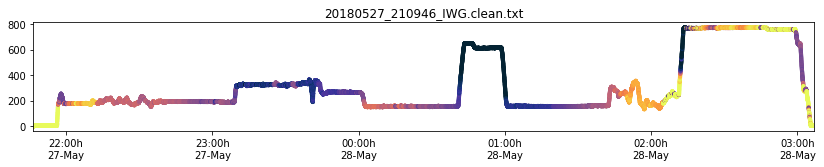

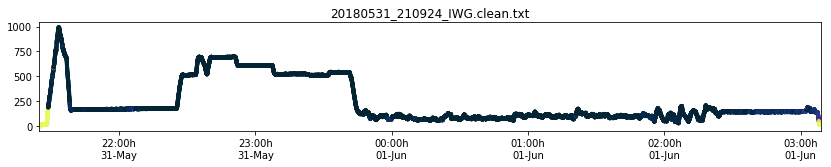

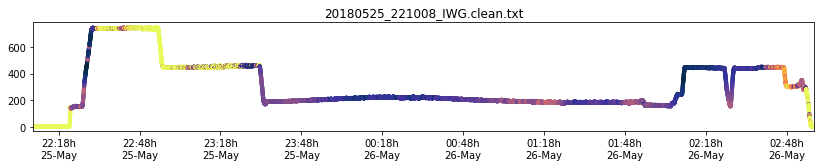

In [12]:
for file in dfs.keys():
    fig = plt.figure(figsize=(14, 2))
    ax1 = fig.add_subplot(111)
    plt.scatter(dfs[file].index,dfs[file]['ALTGPS'],
                s=10,c=dfs[file]['SST'],cmap=cmocean.cm.thermal,
                vmin=lower_limit,vmax=upper_limit)
    ax1.set_xlim(dfs[file].index.min(),dfs[file].index.max())
    xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
    ax1.xaxis.set_major_formatter(xfmt)
    plt.title(file)

### Color Bar Creation

Creating a consistent color bar for the thermal plots.  Maptlotlib can do this inherently but the GMT-Python package

In [13]:
def colorbar(cmap=cmocean.cm.thermal,label=''):

    '''
    ====================
    Customized colorbars
    ====================

    This example shows how to build colorbars without an attached mappable.
    '''

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import cmocean

    # Make a figure and axes with dimensions as desired.
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    cmap = cmap
    norm = mpl.colors.Normalize(vmin=lower_limit, vmax=upper_limit)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label(label)

    # The second example illustrates the use of a ListedColormap, a
    # BoundaryNorm, and extended ends to show the "over" and "under"
    # value colors.
    cmap = mpl.colors.ListedColormap(['r', 'g', 'b', 'c'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    plt.show()

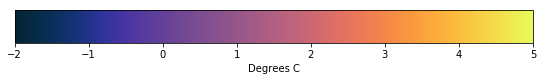

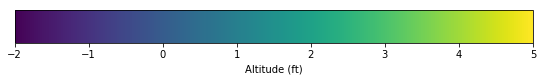

In [14]:
colorbar(cmocean.cm.thermal,'Degrees C')
colorbar('viridis','Altitude (ft)')